In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [6]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [10]:
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [11]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [12]:
!mkdir checkpoints

子目录或文件 checkpoints 已经存在。


In [18]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6485 0.0953 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.5678 0.0948 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4942 0.0946 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5734 0.0954 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5154 0.0992 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5250 0.0967 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5771 0.0968 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5629 0.1031 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4997 0.1054 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4483 0.1048 sec/batch
Nearest to a: verify, schnauzer, drawbridge, knotted, suggests, mul, channels, job,
Nearest to but: monkeys, glaad, taxa, conduction, clergyman, seamus, presper, ogden,
Nearest to where: puppetry, staub, incision, invertebrates, warps, sama, orthographies, killebrew,
Nearest to nine: redmond, glimp

Nearest to http: mais, kobayashi, formalism, cyrillic, herodotus, bouquet, soichiro, well,
Nearest to running: center, yelena, tierney, carina, beacons, mayfield, moravia, overturn,
Nearest to issue: octets, propose, heaps, labyrinths, arlecchino, vindicated, legnica, exhibited,
Nearest to writers: stockpiles, jest, baruch, pike, stein, pace, equivalents, sevens,
Nearest to additional: wilford, comparing, irreversible, scrolls, clashes, hog, the, vocations,
Nearest to question: quarters, propelling, monologue, freethinker, postmodern, nationalrat, forward, saddles,
Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6725 0.1093 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6819 0.1060 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6252 0.1067 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6275 0.1055 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6303 0.1051 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6661 0.1124 sec/batch
Ep

Nearest to where: puppetry, arithmetic, orthographies, incision, invertebrates, describing, cryptanalyst, staub,
Nearest to nine: february, two, alonso, four, five, seven, whitney, redmond,
Nearest to its: sanctioned, transformers, epitomised, bosom, mallard, purr, requisite, brokers,
Nearest to on: allowing, mond, unheated, rowdy, respectively, fed, strasbourg, flocked,
Nearest to this: socially, purest, quirks, sextant, weaned, texts, bosniaks, a,
Nearest to only: separations, magnificence, frontage, tegmark, same, wealthy, luthiers, way,
Nearest to discovered: barr, garden, similarly, biographer, giscard, gaetano, objectivity, celestine,
Nearest to placed: klan, ailey, retrieving, wrestling, survivability, kwok, ephesians, wiring,
Nearest to http: www, com, mais, bouquet, kobayashi, gov, links, html,
Nearest to running: center, yelena, brightest, gardening, automatically, won, beacons, tierney,
Nearest to issue: propose, octets, heaps, arlecchino, bartleby, vindicated, conviction, v

Epoch 3/10 Iteration: 11500 Avg. Training loss: 4.1662 0.0927 sec/batch
Epoch 3/10 Iteration: 11600 Avg. Training loss: 4.2034 0.0907 sec/batch
Epoch 3/10 Iteration: 11700 Avg. Training loss: 4.1957 0.0911 sec/batch
Epoch 3/10 Iteration: 11800 Avg. Training loss: 4.1704 0.0913 sec/batch
Epoch 3/10 Iteration: 11900 Avg. Training loss: 4.1490 0.0908 sec/batch
Epoch 3/10 Iteration: 12000 Avg. Training loss: 4.1938 0.0908 sec/batch
Nearest to a: verify, intervals, mul, mellin, this, drawbridge, bueno, kinetic,
Nearest to but: glaad, englishmen, recognized, schoolchildren, cohesive, prevailing, monkeys, this,
Nearest to where: orthographies, arithmetic, cryptanalyst, describing, puppetry, incision, excl, left,
Nearest to nine: two, four, five, seven, one, february, eight, six,
Nearest to its: sanctioned, transformers, hiragana, counterexample, brokers, mallard, enso, abstraction,
Nearest to on: allowing, unheated, mond, respectively, gaynor, rowdy, jazeera, missiles,
Nearest to this: social

Nearest to writers: alumni, megas, stein, jest, sevens, novella, dominatrices, fiction,
Nearest to additional: pedal, scrolls, separate, comparing, irreversible, methylation, envisioned, palestinian,
Nearest to question: wavefunction, abstracting, nationalrat, monologue, brummell, convened, cool, benefices,
Epoch 4/10 Iteration: 15100 Avg. Training loss: 4.0201 0.0940 sec/batch
Epoch 4/10 Iteration: 15200 Avg. Training loss: 4.0568 0.0925 sec/batch
Epoch 4/10 Iteration: 15300 Avg. Training loss: 4.0283 0.0915 sec/batch
Epoch 4/10 Iteration: 15400 Avg. Training loss: 4.0648 0.0916 sec/batch
Epoch 4/10 Iteration: 15500 Avg. Training loss: 4.0819 0.0918 sec/batch
Epoch 4/10 Iteration: 15600 Avg. Training loss: 4.0620 0.0923 sec/batch
Epoch 4/10 Iteration: 15700 Avg. Training loss: 4.0766 0.0921 sec/batch
Epoch 4/10 Iteration: 15800 Avg. Training loss: 4.1028 0.0935 sec/batch
Epoch 4/10 Iteration: 15900 Avg. Training loss: 4.0555 0.0953 sec/batch
Epoch 4/10 Iteration: 16000 Avg. Training l

Nearest to discovered: barr, lush, deville, krypton, radioactivity, biographer, impenetrable, connoting,
Nearest to placed: wiring, wrestling, topmost, vitruvius, ephesians, gassan, ailanthus, retrieving,
Nearest to http: www, com, htm, html, edu, gov, links, mais,
Nearest to running: tightly, brightest, expandable, runs, plunger, encoders, cve, potentiation,
Nearest to issue: octets, propose, heaps, vindicated, arlecchino, bartleby, petrosian, hisham,
Nearest to writers: alumni, novelists, megas, pace, fiction, novella, stein, jest,
Nearest to additional: methylation, comparing, separate, scrolls, pedal, saad, schedule, palestinian,
Nearest to question: convened, wavefunction, abstracting, brummell, nationalrat, monologue, questions, cool,
Epoch 5/10 Iteration: 19100 Avg. Training loss: 3.9938 0.0925 sec/batch
Epoch 5/10 Iteration: 19200 Avg. Training loss: 3.9364 0.0921 sec/batch
Epoch 5/10 Iteration: 19300 Avg. Training loss: 4.0101 0.0934 sec/batch
Epoch 5/10 Iteration: 19400 Avg. 

Nearest to its: hiragana, sanctioned, the, brokers, piracy, abstraction, counterexample, of,
Nearest to on: the, gaynor, cmi, december, a, savard, external, rapp,
Nearest to this: socially, quicksort, weaned, cocky, remember, primitives, texts, gravitationally,
Nearest to only: specify, because, same, way, called, separations, dips, trichomes,
Nearest to discovered: lush, barr, moons, deville, krypton, bolide, jpl, yasukuni,
Nearest to placed: wiring, topmost, wrestling, gassan, ephesians, ailanthus, superimposed, retrieving,
Nearest to http: www, com, htm, html, edu, gov, links, mais,
Nearest to running: tightly, luxuries, lovingly, encoders, expandable, thumbnail, brightest, runs,
Nearest to issue: octets, propose, petrosian, arlecchino, heaps, hisham, ronald, transparency,
Nearest to writers: alumni, novelists, fiction, pace, novella, playwrights, megas, stein,
Nearest to additional: methylation, straightening, schedule, saad, separate, comparing, pedal, bioleaching,
Nearest to ques

Nearest to where: puppetry, teshuva, describing, left, caracas, surgeon, agere, wendy,
Nearest to nine: two, one, four, five, zero, eight, three, seven,
Nearest to its: hiragana, of, sanctioned, the, separate, counterexample, brokers, russia,
Nearest to on: the, a, of, gaynor, cmi, saint, an, external,
Nearest to this: remember, the, socially, bosniaks, was, weaned, all, quicksort,
Nearest to only: because, in, same, way, specify, called, fluidity, illyrians,
Nearest to discovered: moons, bolide, barr, lush, plead, guez, jpl, yasukuni,
Nearest to placed: wiring, topmost, wrestling, gassan, ailanthus, ephesians, pectoral, baffles,
Nearest to http: www, com, htm, edu, html, gov, shtml, links,
Nearest to running: tightly, ran, lovingly, encoders, luxuries, runs, afc, brightest,
Nearest to issue: octets, petrosian, arlecchino, hisham, propose, ocd, reporters, heaps,
Nearest to writers: novelists, alumni, fiction, pace, novella, stein, playwrights, megas,
Nearest to additional: saad, straig

Nearest to where: other, left, spratly, the, agere, aut, in, describing,
Nearest to nine: one, two, five, four, eight, zero, three, seven,
Nearest to its: the, of, sanctioned, hiragana, counterexample, russia, visceral, in,
Nearest to on: the, a, of, in, and, an, s, before,
Nearest to this: the, all, it, socially, a, was, bosniaks, but,
Nearest to only: in, because, same, called, way, matador, reprimanded, specify,
Nearest to discovered: moons, bolide, grading, barr, jpl, babylonians, yasukuni, sequence,
Nearest to placed: topmost, wiring, wrestling, ailanthus, gassan, baffles, pectoral, ephesians,
Nearest to http: www, com, htm, edu, html, gov, shtml, links,
Nearest to running: ran, lovingly, encoders, tightly, afc, luxuries, nashe, broadway,
Nearest to issue: octets, petrosian, arlecchino, hisham, propose, reporters, heaps, detector,
Nearest to writers: novelists, alumni, fiction, pace, novella, duos, essayists, births,
Nearest to additional: methylation, straightening, saad, tackles

Nearest to on: the, a, in, of, and, s, an, to,
Nearest to this: the, a, all, was, it, in, but, by,
Nearest to only: in, because, same, way, matador, called, specify, reprimanded,
Nearest to discovered: bolide, moons, sequence, grading, plead, inaccuracy, found, olin,
Nearest to placed: topmost, pectoral, lamiales, baffles, wiring, wrestling, gassan, ailanthus,
Nearest to http: www, com, htm, edu, html, gov, shtml, links,
Nearest to running: ran, encoders, lovingly, tightly, multi, argand, ilife, palembang,
Nearest to issue: octets, petrosian, arlecchino, propose, hisham, reporters, however, detector,
Nearest to writers: novelists, fiction, alumni, pace, novella, cartoonists, equivalents, duos,
Nearest to additional: tackles, straightening, methylation, saad, schedule, waived, pedal, sharpest,
Nearest to question: questions, convened, wavefunction, cool, supporters, abstracting, answer, substantive,
Epoch 8/10 Iteration: 35100 Avg. Training loss: 3.8854 0.0917 sec/batch
Epoch 8/10 Itera

Nearest to placed: lamiales, topmost, baffles, transvestite, pectoral, wiring, ailanthus, wrestling,
Nearest to http: www, com, htm, edu, html, gov, shtml, links,
Nearest to running: ran, lovingly, encoders, runs, ilife, broadway, multi, backs,
Nearest to issue: octets, petrosian, reporters, arlecchino, hisham, detector, proposal, ocd,
Nearest to writers: novelists, fiction, alumni, essayists, cartoonists, autodidacts, humanitarians, pace,
Nearest to additional: methylation, scrolls, straightening, tackles, bioleaching, schedule, saad, waived,
Nearest to question: questions, convened, answer, cool, wavefunction, supporters, abstracting, substantive,
Epoch 9/10 Iteration: 39100 Avg. Training loss: 3.8103 0.0930 sec/batch
Epoch 9/10 Iteration: 39200 Avg. Training loss: 3.8577 0.0920 sec/batch
Epoch 9/10 Iteration: 39300 Avg. Training loss: 3.8375 0.0909 sec/batch
Epoch 9/10 Iteration: 39400 Avg. Training loss: 3.8694 0.0908 sec/batch
Epoch 9/10 Iteration: 39500 Avg. Training loss: 3.8889

Nearest to issue: petrosian, octets, reporters, arlecchino, propose, proposal, hisham, hershey,
Nearest to writers: novelists, fiction, alumni, essayists, equivalents, cartoonists, autodidacts, polymaths,
Nearest to additional: scrolls, methylation, hagiography, tackles, saad, straightening, bioleaching, maji,
Nearest to question: questions, answer, convened, invert, nationalrat, supporters, wavefunction, cool,
Epoch 10/10 Iteration: 43100 Avg. Training loss: 3.7647 0.0927 sec/batch
Epoch 10/10 Iteration: 43200 Avg. Training loss: 3.8391 0.0913 sec/batch
Epoch 10/10 Iteration: 43300 Avg. Training loss: 3.8547 0.0917 sec/batch
Epoch 10/10 Iteration: 43400 Avg. Training loss: 3.8418 0.0918 sec/batch
Epoch 10/10 Iteration: 43500 Avg. Training loss: 3.8039 0.0917 sec/batch
Epoch 10/10 Iteration: 43600 Avg. Training loss: 3.9050 0.0902 sec/batch
Epoch 10/10 Iteration: 43700 Avg. Training loss: 3.8405 0.0904 sec/batch
Epoch 10/10 Iteration: 43800 Avg. Training loss: 3.8100 0.0900 sec/batch
E

In [19]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [21]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

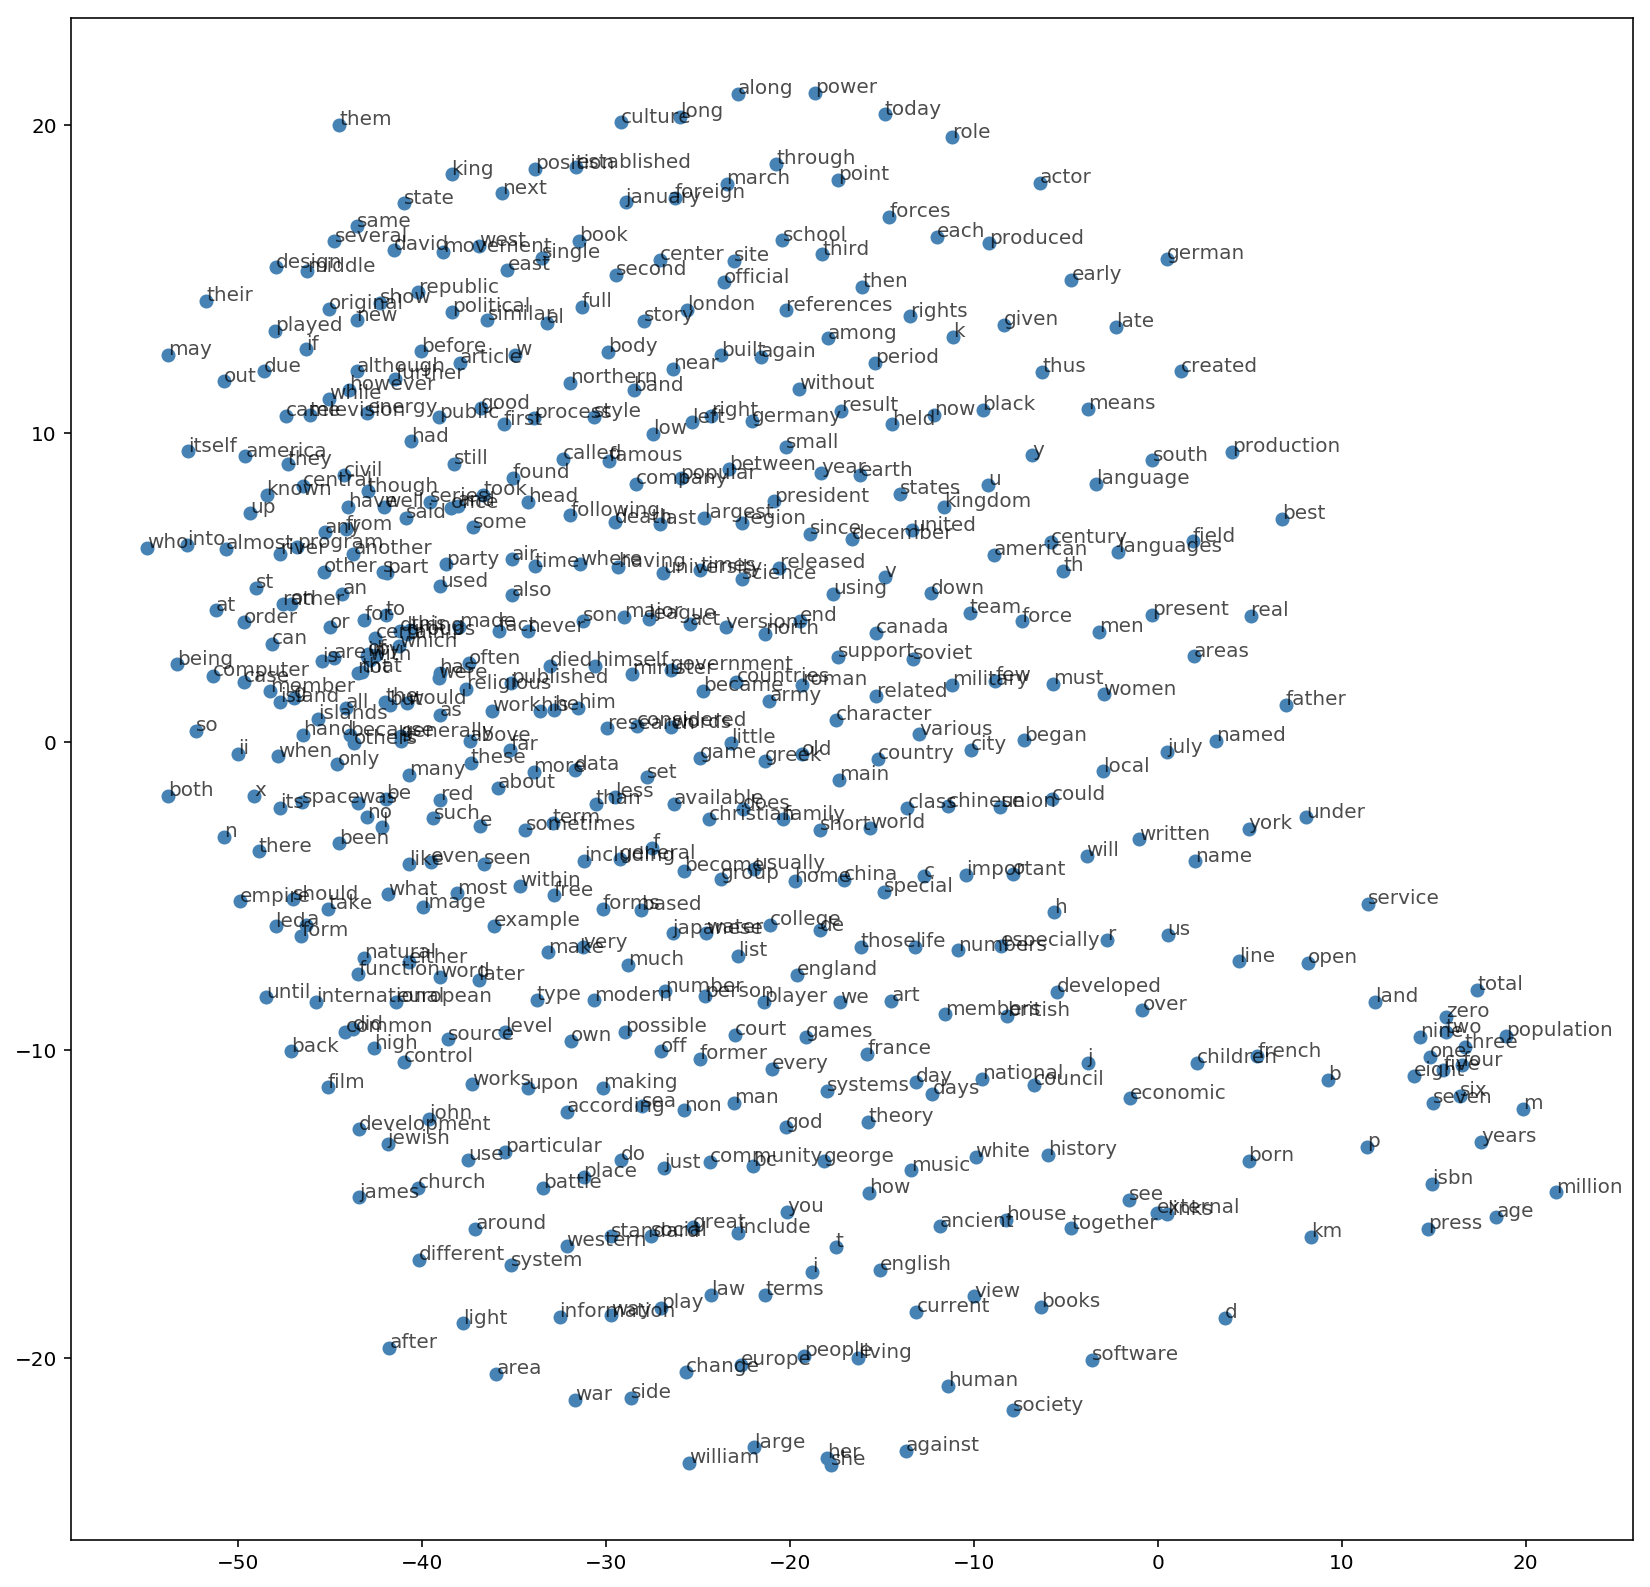

In [22]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)